<a href="https://colab.research.google.com/github/gyasifred/msc-thesis/blob/main/french_twi_seq2seq_nmt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This exercise will demonstrate how to build sequence to sequence models with attention for French-Twi machine translation. This code is based on the tensorflow implementation of the paper [Effective Approaches to Attention-based Neural Machine Translation](https://arxiv.org/abs/1508.04025v5) (Luong et al., 2015).The code snippet are adapted from from [[1]](https://www.tensorflow.org/text/tutorials/nmt_with_attention).

# Import Tensorflow

In [3]:
!pip install "tensorflow-text==2.8.*"
!pip3 install googletrans==3.1.0a0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.9 MB 12.1 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 55 kB 3.3 MB/s 
     |████████████████████████████████| 1.4 MB 27.3 MB/s 
     |████████████████████████████████| 42 kB 1.6 MB/s 
     |████████████████████████████████| 65 kB 3.5 MB/s 
     |████████████████████████████████| 53 kB 2.7 MB/s 
  Created wheel for googletrans: filename=googletrans-3.1.0a0-py3-none-any.whl size=16367 sha256=be730b429899ddcfc51a8b80f156afe15fa23a8c10ed00bf0424c720a232870f
  Stored in directory: /root/.cache/pip/wheels/0c/be/fe/93a6a40ffe386e16089e44dad9018ebab9dc4cb9eb7eab65ae
Successfully built googletrans


In [4]:
import numpy as np
import pickle

import typing
from typing import Any, Tuple

import tensorflow as tf

import tensorflow_text as tf_text

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split

# Preprocess data

In [5]:
# This code was adapted from https://github.com/GhanaNLP/kasa/blob/master/Kasa/Preprocessing.py
# A subclass of the kasafrench for preprocessing data
# import required library
import re
import unicodedata


class Preprocessing:
    # dummy initialization method
    def __init__(self):
        # initialize with some default parameters here later
        pass

    # read in parallel twi - english dataset
    def read_parallel_dataset(self, filepath_1, filepath_2, filepath_3=None):
        if filepath_3 != None:
            # read first language data
            lang_1 = []
            with open(filepath_1, encoding='utf-8') as file:
                line = file.readline()
                cnt = 1
                while line:
                    lang_1.append(line.strip())
                    line = file.readline()
                    cnt += 1

            # read second language data
            lang_2 = []
            with open(filepath_2, encoding='utf-8') as file:

                # twi=file.read()
                line = file.readline()
                cnt = 1
                while line:
                    lang_2.append(line.strip())
                    line = file.readline()
                    cnt += 1
            # Read third Language data
            lang_3 = []
            with open(filepath_3, encoding='utf-8') as file:
                line = file.readline()
                cnt = 1
                while line:
                    lang_3.append(line.strip())
                    line = file.readline()
                    cnt += 1

            return lang_1, lang_2, lang_3
            
        else:
            # read first language data
            lang_1 = []
            with open(filepath_1, encoding='utf-8') as file:
                line = file.readline()
                cnt = 1
                while line:
                    lang_1.append(line.strip())
                    line = file.readline()
                    cnt += 1

            # read second language data
            lang_2 = []
            with open(filepath_2, encoding='utf-8') as file:

                # twi=file.read()
                line = file.readline()
                cnt = 1
                while line:
                    lang_2.append(line.strip())
                    line = file.readline()
                    cnt += 1

            return lang_1, lang_2

    # Define a helper function to remove string accents

    def removeStringAccent(self, s):
        return ''.join(
            c for c in unicodedata.normalize('NFD', s)
            if unicodedata.category(c) != 'Mn'
        )

    # normalize input twi sentence
    def normalize_twi(self, s):
        s = self.removeStringAccent(s)
        s = s.lower()
        s = re.sub(r'([!.?])', r' \1', s)
        s = re.sub(r'[^a-zA-Z.ƆɔɛƐ!?’]+', r' ', s)
        s = re.sub(r'\s+', r' ', s)
        return s

    # normalize input french sentence
    def normalize_FrEn(self, s):
        s = self.removeStringAccent(s)
        s = s.lower()
        s = re.sub(r'([!.?])', r' \1', s)
        s = re.sub(r'[^a-zA-Z.!?]+', r' ', s)
        s = re.sub(r'\s+', r' ', s)
        return s
    
    def writeTotxt(self,destination,data):
        with open(destination, 'w') as f:
            for line in data:
                 f.write(f"{line}\n")

In [6]:
# import preprocessing class 
# Create an instance of tft preprocessing class
preprocessor = Preprocessing()

# Read raw parallel dataset
raw_data_twi, raw_data_fr = preprocessor.read_parallel_dataset(
    filepath_1='/content/drive/MyDrive/verified_twi.txt',
    filepath_2='/content/drive/MyDrive/verified_french.txt'
)

# Normalize the raw data
raw_data_fr = [preprocessor.normalize_FrEn(data) for data in raw_data_fr]
raw_data_twi = [preprocessor.normalize_twi(data) for data in raw_data_twi]

# Load Tokenizer

In [7]:
# Define functions to help reload tokenizer.
# add start and end tokens
#This functions was use in building the tokenizer
#Need to use custmise class to save tokenizer instead

def tf_start_and_end_tokens(text):
    # Split accented characters.
    text = tf_text.normalize_utf8(text, 'NFKD')
    text = tf.strings.lower(text)
    # Strip whitespace.
    text = tf.strings.strip(text)

    text = tf.strings.join(['[START]', text, '[END]'], separator=' ')
    return text
    
# function to load tokenizer
def loadtokenizer(filepath):
    tmp = pickle.load(open(filepath, "rb"))
    temp = tf.keras.layers.TextVectorization.from_config(tmp['config'])
    # You have to call `adapt` with some dummy data (BUG in Keras)
    temp.adapt(tf.data.Dataset.from_tensor_slices(["xyz"]))
    temp.set_weights(tmp['weights'])
    temp.set_vocabulary(tmp['vocabulary'])
    return temp


In [8]:
# load Twi tokenizer
twi_tokenizer = loadtokenizer("/content/drive/MyDrive/twi_tokenizer .pkl")
#load french tokenizer
french_tokenizer = loadtokenizer("/content/drive/MyDrive/french_tokenizer .pkl")


In [9]:
# verify tokenizers
# Print few lines of our tokenizers vocabulary and length
print(f'French Tokenizer:',french_tokenizer.get_vocabulary()[:10])
print(f'French Tokenizer size:',len(french_tokenizer.get_vocabulary()))

print()
print(f'TWI Tokenizer:',twi_tokenizer.get_vocabulary()[-10:])
print(f'TWI Tokenizer size:',len(twi_tokenizer.get_vocabulary()))


French Tokenizer: ['', '[UNK]', '[START]', '[END]', '.', 'a', 'de', 'je', 'est', 'il']
French Tokenizer size: 9553

TWI Tokenizer: ['abamu', 'abambu', 'abada', 'abaafo', 'aakwantuo', 'aa', '.r', '.meda', '.ma', '.abena']
TWI Tokenizer size: 7551


# Create Train and Test sets

In [10]:
# split the dataset into training and test sets
# Keep 10% of the data as test set
train_twi,test_twi,train_fr,test_fr = train_test_split(raw_data_twi,raw_data_fr, test_size=0.1, random_state=42)

In [11]:
# write the preprocess traning and test dataset to a file
preprocessor.writeTotxt('train_twi.txt',train_twi)
preprocessor.writeTotxt('train_fr.txt',train_fr)
preprocessor.writeTotxt('test_twi.txt',test_twi)
preprocessor.writeTotxt('test_fr.txt',test_fr)

## Build tf Dataset

In [12]:
# build tf datasets from traning and test sentences in both languages
train_dataset_fr = tf.data.TextLineDataset('/content/train_fr.txt')
train_dataset_tw = tf.data.TextLineDataset('/content/train_twi.txt')

val_dataset_fr = tf.data.TextLineDataset('/content/test_fr.txt')
val_dataset_tw = tf.data.TextLineDataset('/content/test_twi.txt')

In [13]:
# combine languages into single dataset
trained_combined = tf.data.Dataset.zip((train_dataset_fr,train_dataset_tw))
val_combined = tf.data.Dataset.zip((val_dataset_fr,train_dataset_tw))

In [14]:
# verify trained_combined dataset is correct
for fr,tw in trained_combined.take(5):
  print("French: ", fr.numpy().decode('utf-8'))
  print("Twi: ", tw.numpy().decode('utf-8'))

French:  les premiers colons americains sont arrives au eme siecle .
Twi:  amerika atubrafo a wodi kan no duu hɔ wɔ afeha a ɛto so no mu .
French:  vous devez vous laver les mains .
Twi:  ɛsɛ sɛ wohohoro wo nsa .
French:  appiah horrow est le jour de paie .
Twi:  da a wɔde tua ka no yɛ da koro akatua .
French:  je comprends pourquoi tu aimes asamoah .
Twi:  mitumi hu nea enti a w ani gye asamoa ho
French:  il avait un jean .
Twi:  ɔhyɛ jeans attade


## Create Training Batches

In [15]:
BUFFER_SIZE = len(train_fr) 
BATCH_SIZE = 64
def make_batches(ds):
  return (
  ds
  .cache()
  .shuffle(BUFFER_SIZE)
  .batch(BATCH_SIZE))

In [16]:
# train batches
trained_dataset = make_batches(trained_combined)
# test batches
val_dataset = make_batches(val_combined)

In [17]:
# verify input and target
for  example_input_batch,example_target_batch in trained_dataset.take(1):
  print(example_input_batch[:5])
  print()
  print(example_target_batch[:5])
  break

tf.Tensor(
[b'vous semblez aimer les fruits .'
 b'elle cuisait du pain et des gateaux au four .'
 b'nous devons essayer de proteger l environnement .'
 b'donnons un gros coup de main a asamoah .'
 b'je travaille dans une ville pres de rome .'], shape=(5,), dtype=string)

tf.Tensor(
[b'\xc9\x9bte s\xc9\x9b nea w ani gye aduaba ho .'
 b'\xc9\x94too paanoo ne keeki w\xc9\x94 fononoo no mu .'
 b'\xc9\x9bs\xc9\x9b s\xc9\x9b y\xc9\x9bb\xc9\x94 mm\xc9\x94den b\xc9\x94 nne\xc9\x9bma a atwa y\xc9\x9bn ho ahyia ho ban .'
 b'ma y\xc9\x9bmfa nsamb k\xc9\x9bse bi mmr\xc9\x9b wo .'
 b'mey\xc9\x9b adwuma w\xc9\x94 kurow bi a \xc9\x9bb\xc9\x9bn roma mu .'], shape=(5,), dtype=string)


In [18]:
# Verify tokenizer
example_tokens = french_tokenizer(example_input_batch)
example_tokens[:3, :10]

<tf.Tensor: shape=(3, 10), dtype=int64, numpy=
array([[   2,   13, 1470, 1446,   25,  976,    4,    3,    0,    0],
       [   2,   30, 8558,   37,  865,   40,   39, 2832,   45, 2439],
       [   2,   28,  354,  591,    6, 1373,   19, 3503,    4,    3]])>

In [19]:
input_vocab = np.array(french_tokenizer.get_vocabulary())
tokens = input_vocab[example_tokens[0].numpy()]
' '.join(tokens)

'[START] vous semblez aimer les fruits . [END]              '

The returned token IDs are zero-padded. This can easily be turned into a mask:

Text(0.5, 1.0, 'Mask')

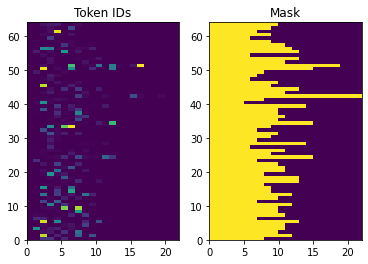

In [20]:
plt.subplot(1, 2, 1)
plt.pcolormesh(example_tokens)
plt.title('Token IDs')

plt.subplot(1, 2, 2)
plt.pcolormesh(example_tokens != 0)
plt.title('Mask')

# Encoder


In [21]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, input_vocab_size, embedding_dim, enc_units):
        super(Encoder, self).__init__()
        self.enc_units = enc_units
        self.input_vocab_size = input_vocab_size

        # The embedding layer converts tokens to vectors
        self.embedding = tf.keras.layers.Embedding(self.input_vocab_size,
                                                   embedding_dim)

        # The GRU RNN layer processes those vectors sequentially.
        self.gru = tf.keras.layers.GRU(self.enc_units,
                                         # Return the sequence and state
                                         return_sequences=True,
                                         return_state=True,
                                         recurrent_initializer='glorot_uniform')

    def call(self, tokens, state=None):
        # The embedding layer looks up the embedding for each token.
        vectors = self.embedding(tokens)

        # The GRU processes the embedding sequence.
        #    output shape: (batch, s, enc_units)
        #    state shape: (batch, enc_units)
        output, state = self.gru(vectors, initial_state=state)

        # 4. Returns the new sequence and its state.
        return output, state

# Create Attention Layer

In [22]:
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super().__init__()
        self.W1 = tf.keras.layers.Dense(units, use_bias=False)
        self.W2 = tf.keras.layers.Dense(units, use_bias=False)

        self.attention = tf.keras.layers.AdditiveAttention()

    def call(self, query, value, mask):
        w1_query = self.W1(query)
        w2_key = self.W2(value)
        query_mask = tf.ones(tf.shape(query)[:-1], dtype=bool)
        value_mask = mask

        context_vector, attention_weights = self.attention(
            inputs=[w1_query, value, w2_key],
            mask=[query_mask, value_mask],
            return_attention_scores=True,
        )
        return context_vector, attention_weights


# Decoder layer

In [23]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self, output_vocab_size, embedding_dim, dec_units):
        super(Decoder, self).__init__()
        self.dec_units = dec_units
        self.output_vocab_size = output_vocab_size
        self.embedding_dim = embedding_dim

        # For Step 1. The embedding layer converts token IDs to vectors
        self.embedding = tf.keras.layers.Embedding(self.output_vocab_size,
                                                   embedding_dim)

        # For Step 2. The RNN keeps track of what's been generated so far.
        self.gru= tf.keras.layers.GRU(self.dec_units,
                                         return_sequences=True,
                                         return_state=True,
                                         recurrent_initializer='glorot_uniform')

        # For step 3. The RNN output will be the query for the attention layer.
        self.attention = BahdanauAttention(self.dec_units)

        # For step 4. Eqn. (3): converting `ct` to `at`
        self.Wc = tf.keras.layers.Dense(dec_units, activation=tf.math.tanh,
                                        use_bias=False)

        # For step 5. This fully connected layer produces the logits for each
        # output token.
        self.fc = tf.keras.layers.Dense(self.output_vocab_size)


class DecoderInput(typing.NamedTuple):
    new_tokens: Any
    enc_output: Any
    mask: Any


class DecoderOutput(typing.NamedTuple):
    logits: Any
    attention_weights: Any


def call(self,
         inputs: DecoderInput,
         state=None) -> Tuple[DecoderOutput, tf.Tensor]:

    # Step 1. Lookup the embeddings
    vectors = self.embedding(inputs.new_tokens)
    # Step 2. Process one step with the RNN
    rnn_output,state = self.gru(vectors, initial_state=state)

    # Step 3. Use the RNN output as the query for the attention over the
    # encoder output.
    context_vector, attention_weights = self.attention(
        query=rnn_output, value=inputs.enc_output, mask=inputs.mask)
    # Step 4. Eqn. (3): Join the context_vector and rnn_output
    #     [ct; ht] shape: (batch t, value_units + query_units)
    context_and_rnn_output = tf.concat([context_vector, rnn_output], axis=-1)

    # Step 4. Eqn. (3): `at = tanh(Wc@[ct; ht])`
    attention_vector = self.Wc(context_and_rnn_output)
    # Step 5. Generate logit predictions:
    logits = self.fc(attention_vector)
    return DecoderOutput(logits, attention_weights), state
    

Decoder.call = call

# Training

In [24]:
class MaskedLoss(tf.keras.losses.Loss):
    def __init__(self):
        self.name = 'masked_loss'
        self.loss = tf.keras.losses.SparseCategoricalCrossentropy(
            from_logits=True, reduction='none')

    def __call__(self, y_true, y_pred):

        # Calculate the loss for each item in the batch.
        loss = self.loss(y_true, y_pred)

        # Mask off the losses on padding.
        mask = tf.cast(y_true != 0, tf.float32)
        loss *= mask

        # Return the total.
        return tf.reduce_sum(loss)


class TrainTranslator(tf.keras.Model):
    def __init__(self, embedding_dim, units,
                 input_text_processor,
                 output_text_processor,
                 use_tf_function=True):
        super().__init__()
        # Build the encoder and decoder
        encoder = Encoder(input_text_processor.vocabulary_size(),
                          embedding_dim, units)
        decoder = Decoder(output_text_processor.vocabulary_size(),
                          embedding_dim, units)

        self.encoder = encoder
        self.decoder = decoder
        self.input_text_processor = input_text_processor
        self.output_text_processor = output_text_processor
        self.use_tf_function = use_tf_function

    def train_step(self, inputs):
        # .shape_checker = ShapeChecker()
        if self.use_tf_function:
            return self._tf_train_step(inputs)
        else:
            return self._train_step(inputs)

    # Implement preprocessing step to:
    # Receive a batch of input_text, target_text from the tf.data.Dataset.
    # Convert those raw text inputs to token-embeddings and masks.
    def _preprocess(self, input_text, target_text):
        # Convert the text to token IDs
        input_tokens = self.input_text_processor(input_text)
        target_tokens = self.output_text_processor(target_text)
        # Convert IDs to masks.
        input_mask = input_tokens != 0

        target_mask = target_tokens != 0
        return input_tokens, input_mask, target_tokens, target_mask

    # the function The _train_step:
    # Run the encoder on the input_tokens to get the encoder_output and encoder_state.
    # Initialize the decoder state and loss.
    # Loop over the target_tokens:
    #   Run the decoder one step at a time.
    #   Calculate the loss for each step.
    # Accumulate the average loss.
    # Calculate the gradient of the loss and use the optimizer to apply updates to the model's trainable_variables.

    def _train_step(self, inputs):
        input_text, target_text = inputs

        (input_tokens, input_mask,
         target_tokens, target_mask) = self._preprocess(input_text, target_text)

        max_target_length = tf.shape(target_tokens)[1]

        with tf.GradientTape() as tape:
            # Encode the input
            enc_output, enc_state = self.encoder(input_tokens)

            # Initialize the decoder's state to the encoder's final state.
            # This only works if the encoder and decoder have the same number of
            # units.
            dec_state = enc_state
            loss = tf.constant(0.0)

            for t in tf.range(max_target_length-1):
                # Pass in two tokens from the target sequence:
                # 1. The current input to the decoder.
                # 2. The target for the decoder's next prediction.
                new_tokens = target_tokens[:, t:t+2]
                step_loss, dec_state = self._loop_step(new_tokens, input_mask,
                                                       enc_output, dec_state)
                loss = loss + step_loss

            # Average the loss over all non padding tokens.
            average_loss = loss / \
                tf.reduce_sum(tf.cast(target_mask, tf.float32))

        # Apply an optimization step
        variables = self.trainable_variables
        gradients = tape.gradient(average_loss, variables)
        self.optimizer.apply_gradients(zip(gradients, variables))

        # Return a dict mapping metric names to current value
        return {'batch_loss': average_loss}

    # The _loop_step method, added below, executes the decoder and calculates the incremental loss and new decoder state (dec_state).

    def _loop_step(self, new_tokens, input_mask, enc_output, dec_state):
        input_token, target_token = new_tokens[:, 0:1], new_tokens[:, 1:2]

        # Run the decoder one step.
        decoder_input = DecoderInput(new_tokens=input_token,
                                     enc_output=enc_output,
                                     mask=input_mask)

        dec_result, dec_state = self.decoder(decoder_input, state=dec_state)

        # `self.loss` returns the total for non-padded tokens
        y = target_token
        y_pred = dec_result.logits
        step_loss = self.loss(y, y_pred)

        return step_loss, dec_state

    @tf.function(input_signature=[[tf.TensorSpec(dtype=tf.string, shape=[None]),
                               tf.TensorSpec(dtype=tf.string, shape=[None])]])
    def _tf_train_step(self, inputs):
        return self._train_step(inputs)

class BatchLogs(tf.keras.callbacks.Callback):
  def __init__(self, key):
    self.key = key
    self.logs = []

  def on_train_batch_end(self, n, logs):
    self.logs.append(logs[self.key])

batch_loss = BatchLogs('batch_loss')

In [25]:
# SET INPUT AND OUTPUT PROCESSOR
input_text_processor = french_tokenizer
output_text_processor = twi_tokenizer

# set Hyerperameters
embedding_dim = 256
units = 1024

In [26]:
train_translator = TrainTranslator(
    embedding_dim, units,
    input_text_processor=input_text_processor,
    output_text_processor=output_text_processor,
    use_tf_function=False)
# Configure the loss and optimizer
train_translator.compile(
    optimizer=tf.optimizers.Adam(),
    loss=MaskedLoss(),
)
train_translator.use_tf_function = True

def loadtokenizer(filepath):
    tmp = pickle.load(open(filepath, "rb"))
    temp = tf.keras.layers.TextVectorization.from_config(tmp['config'])
    # You have to call `adapt` with some dummy data (BUG in Keras)
    temp.adapt(tf.data.Dataset.from_tensor_slices(["xyz"]))
    temp.set_weights(tmp['weights'])
    temp.set_vocabulary(tmp['vocabulary'])
    return temp
  

In [ ]:
train_translator.fit(trained_dataset, epochs=100,
                     callbacks=[batch_loss])

Epoch 1/100
358/358 [==============================] - 134s 325ms/step - batch_loss: 4.2692
Epoch 2/100
358/358 [==============================] - 110s 308ms/step - batch_loss: 3.1297
Epoch 3/100
358/358 [==============================] - 109s 305ms/step - batch_loss: 2.3496
Epoch 4/100
358/358 [==============================] - 111s 311ms/step - batch_loss: 1.7624
Epoch 5/100
358/358 [==============================] - 111s 310ms/step - batch_loss: 1.3089
Epoch 6/100
358/358 [==============================] - 110s 306ms/step - batch_loss: 0.9624
Epoch 7/100
358/358 [==============================] - 109s 306ms/step - batch_loss: 0.6924
Epoch 8/100
358/358 [==============================] - 109s 306ms/step - batch_loss: 0.4870
Epoch 9/100
358/358 [==============================] - 110s 307ms/step - batch_loss: 0.3352
Epoch 10/100
358/358 [==============================] - 110s 306ms/step - batch_loss: 0.2342
Epoch 11/100
358/358 [==============================] - 107s 300ms/step - batch

In [ ]:
plt.plot(batch_loss.logs)
plt.ylim([0, 3])
plt.xlabel('Batch #')
plt.ylabel('CE/token')

# Translator

In [ ]:

class Translator(tf.Module):

    def __init__(self, encoder, decoder, input_text_processor,
                 output_text_processor):
        self.encoder = encoder
        self.decoder = decoder
        self.input_text_processor = input_text_processor
        self.output_text_processor = output_text_processor

        self.output_token_string_from_index = (
            tf.keras.layers.StringLookup(
                vocabulary=output_text_processor.get_vocabulary(),
                mask_token='',
                invert=True))

        # The output should never generate padding, unknown, or start.
        index_from_string = tf.keras.layers.StringLookup(
            vocabulary=output_text_processor.get_vocabulary(), mask_token='')
        token_mask_ids = index_from_string(['', '[UNK]', '[START]']).numpy()

        token_mask = np.zeros(
            [index_from_string.vocabulary_size()], dtype=np.bool)
        token_mask[np.array(token_mask_ids)] = True
        self.token_mask = token_mask

        self.start_token = index_from_string(tf.constant('[START]'))
        self.end_token = index_from_string(tf.constant('[END]'))

    def tokens_to_text(self, result_tokens):
        result_text_tokens = self.output_token_string_from_index(
            result_tokens)
        result_text = tf.strings.reduce_join(result_text_tokens,
                                             axis=1, separator=' ')
        result_text = tf.strings.strip(result_text)
        return result_text

    def sample(self, logits, temperature):
        token_mask = self.token_mask[tf.newaxis, tf.newaxis, :]
        logits = tf.where(self.token_mask, -np.inf, logits)

        if temperature == 0.0:
            new_tokens = tf.argmax(logits, axis=-1)
        else:
            logits = tf.squeeze(logits, axis=1)
            new_tokens = tf.random.categorical(logits/temperature,
                                               num_samples=1)

        return new_tokens

    def translate(self,
                  input_text, *,
                  max_length=50,
                  return_attention=True,
                  temperature=1.0):
        batch_size = tf.shape(input_text)[0]
        input_tokens = self.input_text_processor(input_text)
        enc_output, enc_state = self.encoder(input_tokens)

        dec_state = enc_state
        new_tokens = tf.fill([batch_size, 1], self.start_token)

        result_tokens = []
        attention = []
        done = tf.zeros([batch_size, 1], dtype=tf.bool)

        for _ in range(max_length):
            dec_input = DecoderInput(new_tokens=new_tokens,
                                     enc_output=enc_output,
                                     mask=(input_tokens != 0))

            dec_result, dec_state = self.decoder(dec_input, state=dec_state)

            attention.append(dec_result.attention_weights)

            new_tokens = self.sample(dec_result.logits, temperature)

            # If a sequence produces an `end_token`, set it `done`
            done = done | (new_tokens == self.end_token)
            # Once a sequence is done it only produces 0-padding.
            new_tokens = tf.where(done, tf.constant(
                0, dtype=tf.int64), new_tokens)

            # Collect the generated tokens
            result_tokens.append(new_tokens)

            if tf.executing_eagerly() and tf.reduce_all(done):
                break

        # Convert the list of generates token ids to a list of strings.
        result_tokens = tf.concat(result_tokens, axis=-1)
        result_text = self.tokens_to_text(result_tokens)

        if return_attention:
            attention_stack = tf.concat(attention, axis=1)
            return {'text': result_text, 'attention': attention_stack}
        else:
            return {'text': result_text}

    @tf.function(input_signature=[tf.TensorSpec(dtype=tf.string, shape=[None])])
    def __call__(self, input_text):
        return self.translate(input_text)

In [ ]:
# instantiate a translator
translate = Translator(
    encoder=train_translator.encoder,
    decoder=train_translator.decoder,
    input_text_processor=input_text_processor,
    output_text_processor=output_text_processor,
)

In [ ]:
# Run it on a simple input:
%%time
input_text = tf.constant([
    "Dieu de nos pères.",#Yɛn agyanom Nyankopɔn .'
    "C'est ma vie.",  # 'Eyi ne m’asetra .'
])

result = translate(
    input_text = input_text)

print(result['text'][0].numpy().decode())
print(result['text'][1].numpy().decode())
print()

In [ ]:
# set up a function to plot attention weights
def plot_attention(attention, sentence, predicted_sentence):
  sentence = tf_start_and_end_tokens(sentence).numpy().decode().split()
  predicted_sentence = predicted_sentence.numpy().decode().split() + ['[END]']
  fig = plt.figure(figsize=(10, 10))
  ax = fig.add_subplot(1, 1, 1)

  attention = attention[:len(predicted_sentence), :len(sentence)]

  ax.matshow(attention, cmap='viridis', vmin=0.0)

  fontdict = {'fontsize': 14}

  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  ax.set_xlabel('Input text')
  ax.set_ylabel('Output text')
  plt.suptitle('Attention weights')

In [ ]:
# verify plot attention
i=0
plot_attention(result['attention'][i], input_text[i], result['text'][i])

# Save Model

In [ ]:
tf.saved_model.save(translate, '/content/drive/MyDrive/fr_tw_seq2seq_translator',
                    signatures={'serving_default': translate.__call__})

In [ ]:
reloaded = tf.saved_model.load('/content/drive/MyDrive/fr_tw_seq2seq_translator')
result = reloaded(input_text)

# BLEU


In [ ]:
import nltk
import numpy as np
from nltk.translate.bleu_score import sentence_bleu, corpus_bleu
from nltk.translate.bleu_score import SmoothingFunction


class Bleu():
    def __init__(self, translator):
        self.translator = translator

    def get_bleuscore(self, testfile, referencefile, smothingfunction=None):
        if type(testfile) == str and type(referencefile) == str:
            # Open test file and read lines
            f = open(testfile, "r")
            hypothesis = f.readlines()
            f.close()
            # open refernce file and read lines
            f = open(referencefile, "r")
            reference = f.readlines()
            f.close()
        elif type(testfile) == list and type(referencefile) == list:
            hypothesis = testfile
            reference = referencefile
        else:
            print(f'File must be txt or python list')

        # check the length of our input sentence
        length = len(hypothesis)
        bleu_total = np.array([0., 0., 0.])
        weights = [(1./2, 1./2), (1./3, 1./3, 1./3),
                   (1./4, 1./4, 1./4, 1./4)]
        for i in range(length):
            hypothesis[i] = hypothesis[i]
            reference[i] = reference[i]
            groundtruth = reference[i].lower().replace(" ' ", "'").replace(" .", ".").replace(" ?", "?").replace(" !", "!")\
                .replace(' " ', '" ').replace(' "', '"').replace(" : ", ": ").replace(" ( ", " (")\
                .replace(" ) ", ") ").replace(" , ", ", ").split()
            groundtruth = [groundtruth]
            translated_text = self.translator(
                hypothesis[i]).numpy().decode("utf-8")
            # print("Translated Text: ", translated_text)
            # print("Ground Truth: ", reference[i])
            candidate = translated_text.replace(" ' ", "'").replace(" .", ".").replace(" ?", "?").replace(" !", "!")\
                .replace(' " ', '" ').replace(' "', '"').replace(" : ", ": ").replace(" ( ", " (")\
                .replace(" ) ", ") ").replace(" , ", ", ").split()
            bleu = np.array(sentence_bleu(
                groundtruth, candidate, weights, smoothing_function=smothingfunction))
            bleu_total += bleu

        return f'2-GRAMS: {bleu_total[0]/length}',f'3-GRAMS: {bleu_total[1]/length}',f'4-GRAMS: {bleu_total[2]/length}'

In [ ]:
#iNSTANTIATE OBJECT OF BLEU CLASS AND IT SMOOTHING FUNCTION
smooth= SmoothingFunction()
bleu = Bleu(reloaded)

In [ ]:
# ESTIMATE BLEU SCORE FROM THE TEST DATA
# from list
bleu.get_bleuscore(test_fr,test_twi,smooth.method2)

GoogleAPI bleu

In [ ]:
# Use google API for bidirectional pivot translation of Twi and French
# pivot language = English
# import libraries
from googletrans import Translator, constants
# instantiate a translator object
# initiate translator object
translator = Translator()
# Add Akan to the language supported by this package
# Note the googletrans package has not  been updated to capture the new additions by google since May 2022
# from https://translate.google.com/?sl=en&tl=ak&op=translate , the key and value for Twi is 'ak':'akan'
constants.LANGUAGES['ak'] = 'akan'


class GooglePivot:
    def __init__(self):
        pass

    def evaluate(self, sentences, src_key, dest_key):
        eng_text = translator.translate(sentences, src=src_key, dest='en').text
        print(eng_text)
        output = translator.translate(eng_text, dest=dest_key).text

        return output


class GoogleDirect:
    def __init__(self):
        pass

    def evaluate(self, sentences, src_key, dest_key):

        return translator.translate(sentences, src=src_key, dest=dest_key).text

In [ ]:
import nltk
import numpy as np
from nltk.translate.bleu_score import sentence_bleu, corpus_bleu
from nltk.translate.bleu_score import SmoothingFunction


class GoogleBleu():
    def __init__(self, translator):
        self.translator = translator

    def get_bleuscore(self, testfile, referencefile,src_lang,dest_lang, smothingfunction=None):
        if type(testfile) == str and type(referencefile) == str:
            # Open test file and read lines
            f = open(testfile, "r")
            hypothesis = f.readlines()
            f.close()
            # open refernce file and read lines
            f = open(referencefile, "r")
            reference = f.readlines()
            f.close()
        elif type(testfile) == list and type(referencefile) == list:
            hypothesis = testfile
            reference = referencefile
        else:
            print(f'File must be txt or python list')

        # check the length of our input sentence
        length = len(hypothesis)
        bleu_total = np.array([0., 0., 0.])
        weights = [(1./2, 1./2), (1./3, 1./3, 1./3),
                   (1./4, 1./4, 1./4, 1./4)]
        for i in range(length):
            hypothesis[i] = hypothesis[i]
            reference[i] = reference[i]
            groundtruth = reference[i].lower().replace(" ' ", "'").replace(" .", ".").replace(" ?", "?").replace(" !", "!")\
                .replace(' " ', '" ').replace(' "', '"').replace(" : ", ": ").replace(" ( ", " (")\
                .replace(" ) ", ") ").replace(" , ", ", ").split()
            groundtruth = [groundtruth]
            translated_text = self.translator.evaluate(hypothesis[i],src_key=src_lang, dest_key=dest_lang)
            # print("Translated Text: ", translated_text)
            # print("Ground Truth: ", reference[i])
            candidate = translated_text.replace(" ' ", "'").replace(" .", ".").replace(" ?", "?").replace(" !", "!")\
                .replace(' " ', '" ').replace(' "', '"').replace(" : ", ": ").replace(" ( ", " (")\
                .replace(" ) ", ") ").replace(" , ", ", ").split()
            bleu = np.array(sentence_bleu(
                groundtruth, candidate, weights, smoothing_function=smothingfunction))
            bleu_total += bleu

        return f'2-GRAMS: {bleu_total[0]/length}',f'3-GRAMS: {bleu_total[1]/length}',f'4-GRAMS: {bleu_total[2]/length}'

In [ ]:
# instantiate GoogleDirect class
google_translate = GoogleDirect()
google_bleu = GoogleBleu(google_translate)

In [ ]:
%%time
google_bleu.get_bleuscore(test_fr,test_twi,'fr','ak',smooth.method2)